# Survival Analysis of Different Drug Treatments

**Import Modules and set up dataframe using uis.csv dataset**

In [43]:
from lifelines import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
from lifelines.plotting import plot_lifetimes as lplt


df = pd.read_csv('uis.csv')

df_r = df.loc[:,["age","ndrugtx","treat","site","time","censor","herco"]]

**What the UIS Data Looks like**

In [44]:
df_r.head()

,age,ndrugtx,treat,site,time,censor,herco
0,39.0,1.0,1,0,188,1,3
1,33.0,8.0,1,0,26,1,3
2,33.0,3.0,1,0,207,1,2
3,32.0,1.0,0,0,144,1,3
4,24.0,5.0,1,0,551,0,2


The goal of the UIS data is to model time until return to drug use for patients enrolled in two different residential treatment programs that differed in length (treat=0 is the short program and treat=1 is the long program).  The patients were randomly assigned to two different sites (site=0 is site A and site=1 is site B).  The variable age indicates age at enrollment, herco indicates heroin or cocaine use in the past three months (herco=1 indicates heroin and cocaine use, herco=2 indicates either heroin or cocaine use and herco=3 indicates neither heroin nor cocaine use) and ndrugtx indicates the number of previous drug treatments.  The variables time contains the time until return to drug use and the censor variable indicates whether the subject returned to drug use (censor=1 indicates return to drug use and censor=0 otherwise).

**Varience in the Dataset**

In [45]:
categories = [i  for i in df_r.columns]

categories.remove('age')
categories.remove('time')
categories.remove('ndrugtx')

for cat in categories:
    print('Column Name: ',cat)
    print(df_r[cat].value_counts())
    print('-----------------------------')

df_r.info()

Column Name:  treat
0    320
1    308
Name: treat, dtype: int64
-----------------------------
Column Name:  site
0    444
1    184
Name: site, dtype: int64
-----------------------------
Column Name:  censor
1    508
0    120
Name: censor, dtype: int64
-----------------------------
Column Name:  herco
1    289
3    225
2    114
Name: herco, dtype: int64
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 7 columns):
age        623 non-null float64
ndrugtx    611 non-null float64
treat      628 non-null int64
site       628 non-null int64
time       628 non-null int64
censor     628 non-null int64
herco      628 non-null int64
dtypes: float64(2), int64(5)
memory usage: 34.5 KB


**Why are we using Survival Analysis**

In the figure below, the red lines denote the lifespan of individuals where the death event has been observed, and the blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). If we are asked to estimate the average lifetime of our population, and we naively decided to not included the right-censored individuals, it is clear that we would be severely underestimating the true average lifespan.

Text(0.5, 1.0, 'Time to treat our population, at $t=300$')

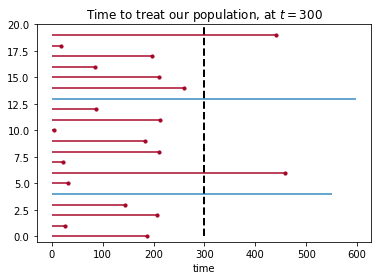

In [46]:
from lifelines.plotting import plot_lifetimes
T = df_r['time']
T = T[:20]
E = df_r['censor']
E = E[:20]


ax = plot_lifetimes(T,E)

ax.vlines(300, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Time to treat our population, at $t=300$")


**Univariate Analysis**

In survival analysis it is highly recommended to look at the Kaplan-Meier curves for all the categorical predictors. This will provide insight into the shape of the survival function for each group and give an idea of whether or not the groups are proportional (i.e. the survival functions are approximately parallel). 

Median User Return Time from Short Term treatment 131.0


NameError: name 'ax1' is not defined

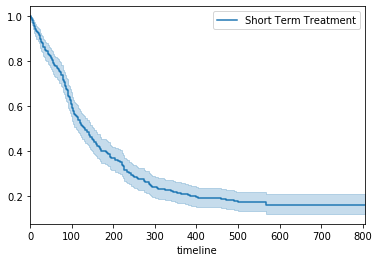

In [47]:
T = df_r['time']
C = df_r['censor']

groups = df_r['treat']           
short = (groups == 0)  
long = (groups == 1)         

kmf = KaplanMeierFitter()

kmf.fit(T[short], C[short], label='Short Term Treatment')    ## fit the cohort 1 data
ax = kmf.plot()
median_ = kmf.median_survival_time_
print('Median User Return Time from Short Term treatment',median_)


kmf.fit(T[long], C[long], label='Long Term Treatment')         ## fit the cohort 2 data
ax = kmf.plot(ax=ax1)
median_ = kmf.median_survival_time_
print('Median User Return Time from Long Term treatment',median_)

kmf.plot()

Median User Return Time from Short Term treatment 156.0
Median User Return Time from Long Term treatment 198.0


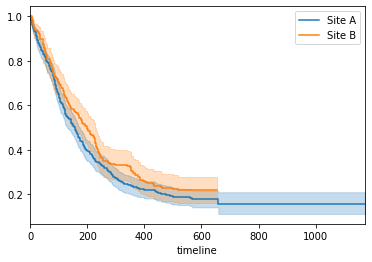

In [55]:
T = df_r['time']
C = df_r['censor']

groups = df_r['site']           
A = (groups == 0)  
B = (groups == 1)         

kmf = KaplanMeierFitter()

kmf.fit(T[A], C[A], label='Site A')    ## fit the cohort 1 data
ax = kmf.plot()
median_ = kmf.median_survival_time_
print('Median User Return Time from Short Term treatment',median_)


kmf.fit(T[B], C[B], label='Site B')         ## fit the cohort 2 data
ax = kmf.plot(ax=ax1)
median_ = kmf.median_survival_time_
print('Median User Return Time from Long Term treatment',median_)

kmf.plot()

Heroine and Cocaine 170.0
Heroine or Cocaine 142.0
Drug Free 168.0


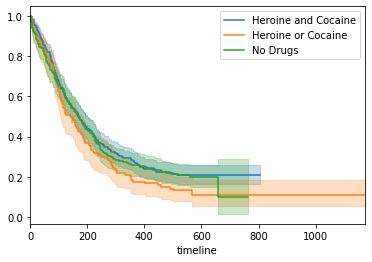

In [53]:
T = df_r['time']
C = df_r['censor']

groups = df_r['herco']           
A = (groups == 1)  
B = (groups == 2)
D = (groups == 3)

kmf = KaplanMeierFitter()

kmf.fit(T[A], C[A], label='Heroine and Cocaine')    ## fit the cohort 1 data
ax = kmf.plot()
median_ = kmf.median_survival_time_
print('Heroine and Cocaine',median_)




kmf.fit(T[B], C[B], label='Heroine or Cocaine')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
print('Heroine or Cocaine',median_)



kmf.fit(T[D], C[D], label='No Drugs')         ## fit the cohort 3 data
kmf.plot(ax=ax1)
median_ = kmf.median_survival_time_
print('Drug Free',median_)




In [48]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
print(calculate_pvalues(df_r))

            age ndrugtx   treat    site    time  censor   herco
age           0       0  0.2576  0.3047  0.0823  0.1322  0.2819
ndrugtx       0       0  0.8529  0.0201  0.0009  0.0005   0.005
treat    0.2576  0.8529       0  0.5354  0.0061  0.2605  0.0589
site     0.3047  0.0201  0.5354       0  0.2121  0.2896  0.0042
time     0.0823  0.0009  0.0061  0.2121       0       0  0.5569
censor   0.1322  0.0005  0.2605  0.2896       0       0  0.6983
herco    0.2819   0.005  0.0589  0.0042  0.5569  0.6983       0


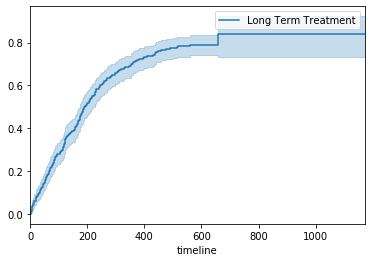

In [49]:
kmf.plot_cumulative_density()

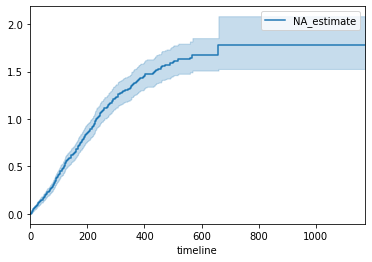

In [50]:
T = df_r['time']
C = df_r['censor']

naf = NelsonAalenFitter()
naf.fit(T,event_observed=C)
naf.plot()

In [51]:
'''
In real life situations along with the event data we also have the covariates of the subject. 
In such cases, it is very important to know about the impact of covariates on the survival curve.
'''

df_dummy = pd.get_dummies(df_r)
a1 = df_dummy['age'].mean()
a2 = df_dummy["ndrugtx"].mean()

df_dummy['age'].fillna(value=a1, inplace=True)
df_dummy["ndrugtx"].fillna(value=a2, inplace=True)

  
cph = CoxPHFitter()
cph.fit(df_dummy, duration_col='time', event_col='censor')


<lifelines.CoxPHFitter: fitted with 628 total observations, 120 right-censored observations>

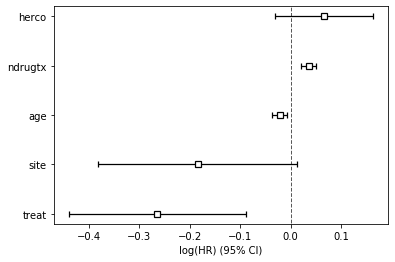

In [59]:
cph.plot()

In [61]:
cph.predict_partial_hazard(df_dummy)

,0
0,0.756057
1,1.104674
2,0.866504
3,1.147707
4,1.132790
...,...
623,0.718946
624,0.890409
625,0.858634
626,0.811457


In [62]:
cph.predict_survival_function(df_dummy)


,0,1,2,3,4,5,6,7,8,9,...,618,619,620,621,622,623,624,625,626,627
2.0,0.998840,0.998305,0.998671,0.998239,0.998262,0.998762,0.996275,0.998437,0.998859,0.998566,...,0.998363,0.999027,0.998541,0.998617,0.998478,0.998897,0.998634,0.998683,0.998755,0.998810
3.0,0.995362,0.993231,0.994686,0.992968,0.993059,0.995049,0.985165,0.993755,0.995440,0.994269,...,0.993460,0.996110,0.994170,0.994475,0.993919,0.995589,0.994540,0.994735,0.995023,0.995242
4.0,0.990718,0.986467,0.989369,0.985944,0.986125,0.990094,0.970464,0.987512,0.990874,0.988537,...,0.986924,0.992211,0.988338,0.988947,0.987838,0.991172,0.989078,0.989466,0.990041,0.990477
5.0,0.986068,0.979709,0.984049,0.978927,0.979198,0.985133,0.955894,0.981271,0.986301,0.982803,...,0.980392,0.988304,0.982506,0.983417,0.981758,0.986747,0.983612,0.984192,0.985054,0.985707
6.0,0.982571,0.974638,0.980051,0.973663,0.974001,0.981404,0.945039,0.976585,0.982863,0.978496,...,0.975489,0.985365,0.978126,0.979262,0.977193,0.983420,0.979506,0.980230,0.981306,0.982121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734.0,0.251429,0.133030,0.205507,0.122976,0.126372,0.229026,0.011811,0.155600,0.257357,0.181423,...,0.142470,0.314229,0.176106,0.192914,0.163393,0.269058,0.196729,0.208482,0.227238,0.242541
762.0,0.251429,0.133030,0.205507,0.122976,0.126372,0.229026,0.011811,0.155600,0.257357,0.181423,...,0.142470,0.314229,0.176106,0.192914,0.163393,0.269058,0.196729,0.208482,0.227238,0.242541
763.0,0.251429,0.133030,0.205507,0.122976,0.126372,0.229026,0.011811,0.155600,0.257357,0.181423,...,0.142470,0.314229,0.176106,0.192914,0.163393,0.269058,0.196729,0.208482,0.227238,0.242541
805.0,0.251429,0.133030,0.205507,0.122976,0.126372,0.229026,0.011811,0.155600,0.257357,0.181423,...,0.142470,0.314229,0.176106,0.192914,0.163393,0.269058,0.196729,0.208482,0.227238,0.242541


In [63]:
cph.predict_median(df_dummy)

,0.5
0,220.0
1,152.0
2,188.0
3,144.0
4,147.0
...,...
623,226.0
624,184.0
625,190.0
626,200.0


In [65]:
cph.print_summary()

NameError: name 'pd' is not defined